### Libraries and functions

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
from BorutaShap import BorutaShap
from powershap  import PowerShap
import shapicant
from tqdm import tqdm
from SHAPEffects import FeatureSelector
import random
import shap
import os
import sys
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel
os.environ['PYTHONHASHSEED'] = str(1234)
random.seed(1234)
np.random.seed(1234)
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'serif'

C:\Users\csebastian\.conda\envs\BrainEN_v1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Taken from PowerSHAP paper
def scores_calc_print(Y,Y_pred,print_bool):
    if len(Y_pred) > 1:
        R2_total = r2_score(Y,Y_pred)
    else:
        R2_total = -1
    RMSE_total = mean_squared_error(Y,Y_pred, squared=False)
    MAE_total = mean_absolute_error(Y,Y_pred)
    
    if print_bool:
        print(tabulate([[RMSE_total, MAE_total,R2_total]], ["RMSE","MAE","R²"], tablefmt="grid"))
    else:
        return {"R2":R2_total,"RMSE":RMSE_total,"MAE":MAE_total}

### Data

In [3]:
current_db = pd.read_csv(r"Data/datos_2019_v0.csv", index_col = 0)
# current_db = current_db.reset_index()
current_db['fecha_completa'] = pd.to_datetime(current_db.fecha_completa)

Index_col = "fecha_completa"
target_col = "md_espana"

current_db = current_db.reset_index(drop=True)

In [4]:
current_db['hora'] = current_db.fecha_completa.dt.hour

In [5]:
list(current_db.columns)

['fecha',
 'hora',
 'pbf_hidraulica_ugh',
 'pbf_hidraulica_no_ugh',
 'pbf_nuclear',
 'pbf_ciclo_combinado',
 'pbf_eolica_terrestre',
 'pbf_solar_fotovoltaica',
 'pbf_solar_termica',
 'pbf_biomasa',
 'pbf_biogas',
 'potencia_indisponible_de_generacion_en_pbf',
 'capacidad_intercambio_francia_importacion',
 'capacidad_intercambio_francia_exportacion',
 'prevision_de_la_produccion_eolica',
 'generacion_prevista_solar_fotovoltaica',
 'generacion_prevista_solar_termica',
 'demanda_prevista',
 'demanda_programada',
 'md_espana',
 'mi1_espana',
 'mi2_espana',
 'mi3_espana',
 'asignacion_banda_de_regulacion_secundaria_a_subir',
 'asignacion_banda_de_regulacion_secundaria_a_bajar',
 'precio_banda_de_regulacion_secundaria',
 'asignacion_gestion_de_desvios_subir',
 'asignacion_gestion_de_desvios_bajar',
 'asignacion_regulacion_terciaria_subir',
 'precio_regulacion_terciaria_bajar',
 'precio_regulacion_terciaria_subir',
 'energia_utilizada_de_regulacion_secundaria_subir',
 'energia_utilizada_de_re

In [6]:
current_db

,fecha,hora,pbf_hidraulica_ugh,pbf_hidraulica_no_ugh,pbf_nuclear,pbf_ciclo_combinado,pbf_eolica_terrestre,pbf_solar_fotovoltaica,pbf_solar_termica,pbf_biomasa,...,q1_carbon,q3_carbon,min_carbon,max_carbon,curtosis_carbon,skew_carbon,variacion_intra1,variacion_intra2,variacion_intra3,variacion_temperatura
0,2019-01-09,1,626.1,539.4,7097.2,906.0,10504.9,7.1,42.0,315.6,...,81.901020,83.225000,80.95,85.15,-0.490645,0.409297,-1.00,1.74,-0.85,-2.39
1,2019-01-09,2,708.4,529.7,7098.1,565.0,10330.0,7.1,66.0,313.0,...,81.878061,83.225000,80.95,85.15,-0.485770,0.431687,0.00,1.25,-0.68,-2.42
2,2019-01-09,3,697.0,517.6,7097.2,554.0,10150.0,7.1,90.0,313.8,...,81.855102,83.225000,80.95,85.15,-0.482014,0.453319,0.30,0.50,-2.02,-2.78
3,2019-01-09,4,730.7,519.4,7098.1,404.0,9971.9,7.1,66.0,313.4,...,81.832143,83.225000,80.95,85.15,-0.479371,0.474127,0.99,1.00,-0.06,-3.39
4,2019-01-09,5,713.8,521.8,7098.1,404.0,9931.5,7.1,98.0,313.6,...,81.809184,83.225000,80.95,85.15,-0.477829,0.494049,0.50,0.00,1.50,-3.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31839,2022-08-27,20,919.0,362.7,6880.9,10269.2,4548.0,3779.4,1485.7,514.8,...,377.975000,401.138776,374.25,406.10,-1.672178,0.281929,-0.10,3.00,30.00,1.29
31840,2022-08-27,21,2322.0,383.1,6876.9,10344.0,4910.3,830.8,959.9,485.3,...,377.975000,401.430612,374.25,406.10,-1.682748,0.277390,0.00,3.98,11.70,1.57
31841,2022-08-27,22,2694.1,397.1,6881.9,10374.3,5154.6,53.2,520.6,485.3,...,377.975000,401.722449,374.25,406.10,-1.692465,0.273280,-1.86,2.00,7.99,1.79
31842,2022-08-27,23,2586.7,392.4,6903.9,10393.7,5236.6,7.7,463.8,487.0,...,377.975000,402.014286,374.25,406.10,-1.701361,0.269585,5.14,11.96,24.46,1.76


In [7]:
current_db['hueco_termico_real'] = current_db.demanda_real - current_db.generacion_treal_eolica - current_db.generacion_treal_solar_fotovoltaica
current_db['hueco_termico_casado'] = current_db.phfc_demanda_programada - current_db.phf3_eolica_terrestre - current_db.phf3_solar_fotovoltaica
current_db['hueco_termico_previsto_1d'] = current_db.prevision_diaria_d1_demanda - current_db.prevision_eolica_diaria_d1 - current_db.generacion_prevista_solar_fotovoltaica
current_db['hueco_termico_previsto_3h'] = current_db.prevision_h3_demanda - current_db.prevision_eolica_intradia_h3 - current_db.prevision_fotovoltaica_intradia_h3

In [8]:
current_db['hueco_termico_real_24'] = current_db['hueco_termico_real'].shift(24)
current_db['hueco_termico_real_48'] = current_db['hueco_termico_real'].shift(48)
current_db['hueco_termico_real_72'] = current_db['hueco_termico_real'].shift(72)
current_db['hueco_termico_real_168'] = current_db['hueco_termico_real'].shift(168)

current_db['hueco_termico_casado_24'] = current_db['hueco_termico_casado'].shift(24)
current_db['hueco_termico_casado_48'] = current_db['hueco_termico_casado'].shift(48)
current_db['hueco_termico_casado_72'] = current_db['hueco_termico_casado'].shift(72)
current_db['hueco_termico_casado_168'] = current_db['hueco_termico_casado'].shift(168)

current_db['hueco_termico_previsto_1d_24'] = current_db['hueco_termico_previsto_1d'].shift(24)
current_db['hueco_termico_previsto_1d_48'] = current_db['hueco_termico_previsto_1d'].shift(48)
current_db['hueco_termico_previsto_1d_72'] = current_db['hueco_termico_previsto_1d'].shift(72)
current_db['hueco_termico_previsto_1d_168'] = current_db['hueco_termico_previsto_1d'].shift(168)

current_db['hueco_termico_previsto_3h_24'] = current_db['hueco_termico_previsto_3h'].shift(24)
current_db['hueco_termico_previsto_3h_48'] = current_db['hueco_termico_previsto_3h'].shift(48)
current_db['hueco_termico_previsto_3h_72'] = current_db['hueco_termico_previsto_3h'].shift(72)
current_db['hueco_termico_previsto_3h_168'] = current_db['hueco_termico_previsto_3h'].shift(168)

In [9]:
current_db = current_db.dropna()

In [10]:
selected_features = ['hora',
#  'capacidad_intercambio_francia_importacion',
#  'capacidad_intercambio_francia_exportacion',
 'prevision_de_la_produccion_eolica',
 'generacion_prevista_solar_fotovoltaica',
 'generacion_prevista_solar_termica',
#  'precio_de_los_desvios_medidos_a_subir',
#  'precio_de_los_desvios_medidos_a_bajar',
#  'intercambio_comercial_francia_importacion',
#  'intercambio_comercial_francia_exportacion',
#  'prevision_de_la_demanda_residual',
#  'potencia_disponible_nuclear',
 'prevision_eolica_diaria_d1',
 'prevision_renovable_diaria_d1',
 'prevision_diaria_d1_demanda',
#  'fecha_completa',
#  'pmd',
 'dia_semana',
#  'potencia_indisponible_de_generacion_en_pbf_24',
#  'potencia_indisponible_de_generacion_en_pbf_48',
#  'potencia_indisponible_de_generacion_en_pbf_72',
#  'potencia_indisponible_de_generacion_en_pbf_168',
#  'capacidad_intercambio_francia_importacion_24',
#  'capacidad_intercambio_francia_importacion_48',
#  'capacidad_intercambio_francia_importacion_72',
#  'capacidad_intercambio_francia_importacion_168',
#  'capacidad_intercambio_francia_exportacion_24',
#  'capacidad_intercambio_francia_exportacion_48',
#  'capacidad_intercambio_francia_exportacion_72',
#  'capacidad_intercambio_francia_exportacion_168',
 'prevision_de_la_produccion_eolica_24',
 'prevision_de_la_produccion_eolica_48',
 'prevision_de_la_produccion_eolica_72',
 'prevision_de_la_produccion_eolica_168',
 'generacion_prevista_solar_fotovoltaica_24',
 'generacion_prevista_solar_fotovoltaica_48',
 'generacion_prevista_solar_fotovoltaica_72',
 'generacion_prevista_solar_fotovoltaica_168',
 'generacion_prevista_solar_termica_24',
 'generacion_prevista_solar_termica_48',
 'generacion_prevista_solar_termica_72',
 'generacion_prevista_solar_termica_168',
#  'demanda_programada_24',
#  'demanda_programada_48',
#  'demanda_programada_72',
#  'demanda_programada_168',
 'md_espana_24',
 'md_espana_48',
 'md_espana_72',
 'md_espana_168',
 'mi1_espana_24',
 'mi1_espana_48',
 'mi1_espana_72',
 'mi1_espana_168',
 'mi2_espana_24',
 'mi2_espana_48',
 'mi2_espana_72',
 'mi2_espana_168',
 'mi3_espana_24',
 'mi3_espana_48',
 'mi3_espana_72',
 'mi3_espana_168',
 'asignacion_banda_de_regulacion_secundaria_a_subir_24',
 'asignacion_banda_de_regulacion_secundaria_a_subir_48',
 'asignacion_banda_de_regulacion_secundaria_a_subir_72',
 'asignacion_banda_de_regulacion_secundaria_a_subir_168',
 'asignacion_banda_de_regulacion_secundaria_a_bajar_24',
 'asignacion_banda_de_regulacion_secundaria_a_bajar_48',
 'asignacion_banda_de_regulacion_secundaria_a_bajar_72',
 'asignacion_banda_de_regulacion_secundaria_a_bajar_168',
 'precio_banda_de_regulacion_secundaria_24',
 'precio_banda_de_regulacion_secundaria_48',
 'precio_banda_de_regulacion_secundaria_72',
 'precio_banda_de_regulacion_secundaria_168',
 'asignacion_gestion_de_desvios_subir_24',
 'asignacion_gestion_de_desvios_subir_48',
 'asignacion_gestion_de_desvios_subir_72',
 'asignacion_gestion_de_desvios_subir_168',
 'asignacion_gestion_de_desvios_bajar_24',
 'asignacion_gestion_de_desvios_bajar_48',
 'asignacion_gestion_de_desvios_bajar_72',
 'asignacion_gestion_de_desvios_bajar_168',
 'asignacion_regulacion_terciaria_subir_24',
 'asignacion_regulacion_terciaria_subir_48',
 'asignacion_regulacion_terciaria_subir_72',
 'asignacion_regulacion_terciaria_subir_168',
 'precio_regulacion_terciaria_bajar_24',
 'precio_regulacion_terciaria_bajar_48',
 'precio_regulacion_terciaria_bajar_72',
 'precio_regulacion_terciaria_bajar_168',
 'precio_regulacion_terciaria_subir_24',
 'precio_regulacion_terciaria_subir_48',
 'precio_regulacion_terciaria_subir_72',
 'precio_regulacion_terciaria_subir_168',
 'energia_utilizada_de_regulacion_secundaria_subir_24',
 'energia_utilizada_de_regulacion_secundaria_subir_48',
 'energia_utilizada_de_regulacion_secundaria_subir_72',
 'energia_utilizada_de_regulacion_secundaria_subir_168',
 'energia_utilizada_de_regulacion_secundaria_bajar_24',
 'energia_utilizada_de_regulacion_secundaria_bajar_48',
 'energia_utilizada_de_regulacion_secundaria_bajar_72',
 'energia_utilizada_de_regulacion_secundaria_bajar_168',
 'precio_de_utilizacion_de_secundaria_subir_24',
 'precio_de_utilizacion_de_secundaria_subir_48',
 'precio_de_utilizacion_de_secundaria_subir_72',
 'precio_de_utilizacion_de_secundaria_subir_168',
 'precio_de_utilizacion_de_secundaria_bajar_24',
 'precio_de_utilizacion_de_secundaria_bajar_48',
 'precio_de_utilizacion_de_secundaria_bajar_72',
 'precio_de_utilizacion_de_secundaria_bajar_168',
 'precio_de_los_desvios_medidos_a_subir_24',
 'precio_de_los_desvios_medidos_a_subir_48',
 'precio_de_los_desvios_medidos_a_subir_72',
 'precio_de_los_desvios_medidos_a_subir_168',
 'precio_de_los_desvios_medidos_a_bajar_24',
 'precio_de_los_desvios_medidos_a_bajar_48',
 'precio_de_los_desvios_medidos_a_bajar_72',
 'precio_de_los_desvios_medidos_a_bajar_168',
#  'demanda_real_24',
#  'demanda_real_48',
#  'demanda_real_72',
#  'demanda_real_168',
 'desvios_generacion_demanda_24',
 'desvios_generacion_demanda_48',
 'desvios_generacion_demanda_72',
 'desvios_generacion_demanda_168',
#  'energia_asignada_en_spot_intradiario_24',
#  'energia_asignada_en_spot_intradiario_48',
#  'energia_asignada_en_spot_intradiario_72',
#  'energia_asignada_en_spot_intradiario_168',
#  'intercambio_comercial_francia_importacion_24',
#  'intercambio_comercial_francia_importacion_48',
#  'intercambio_comercial_francia_importacion_72',
#  'intercambio_comercial_francia_importacion_168',
#  'intercambio_comercial_francia_exportacion_24',
#  'intercambio_comercial_francia_exportacion_48',
#  'intercambio_comercial_francia_exportacion_72',
#  'intercambio_comercial_francia_exportacion_168',
#  'prevision_de_la_demanda_residual_24',
#  'prevision_de_la_demanda_residual_48',
#  'prevision_de_la_demanda_residual_72',
#  'prevision_de_la_demanda_residual_168',
#  'pbf_demanda_24',
#  'pbf_demanda_48',
#  'pbf_demanda_72',
#  'pbf_demanda_168',
#  'pbf_generacion_24',
#  'pbf_generacion_48',
#  'pbf_generacion_72',
#  'pbf_generacion_168',
 'md_francia_24',
 'md_francia_48',
 'md_francia_72',
 'md_francia_168',
#  'volumen_mic_24',
#  'volumen_mic_48',
#  'volumen_mic_72',
#  'volumen_mic_168',
#  'potencia_disponible_nuclear_24',
#  'potencia_disponible_nuclear_48',
#  'potencia_disponible_nuclear_72',
#  'potencia_disponible_nuclear_168',
 'prevision_eolica_diaria_d1_24',
 'prevision_eolica_diaria_d1_48',
 'prevision_eolica_diaria_d1_72',
 'prevision_eolica_diaria_d1_168',
 'prevision_eolica_intradia_h3_24',
 'prevision_eolica_intradia_h3_48',
 'prevision_eolica_intradia_h3_72',
 'prevision_eolica_intradia_h3_168',
 'prevision_renovable_diaria_d1_24',
 'prevision_renovable_diaria_d1_48',
 'prevision_renovable_diaria_d1_72',
 'prevision_renovable_diaria_d1_168',
 'prevision_renovable_intradia_h3_24',
 'prevision_renovable_intradia_h3_48',
 'prevision_renovable_intradia_h3_72',
 'prevision_renovable_intradia_h3_168',
 'prevision_fotovoltaica_intradia_h3_24',
 'prevision_fotovoltaica_intradia_h3_48',
 'prevision_fotovoltaica_intradia_h3_72',
 'prevision_fotovoltaica_intradia_h3_168',
 'asignacion_regulacion_terciaria_bajar_24',
 'asignacion_regulacion_terciaria_bajar_48',
 'asignacion_regulacion_terciaria_bajar_72',
 'asignacion_regulacion_terciaria_bajar_168',
 'prevision_h3_demanda_24',
 'prevision_h3_demanda_48',
 'prevision_h3_demanda_72',
 'prevision_h3_demanda_168',
 'phfc_demanda_programada_24',
 'phfc_demanda_programada_48',
 'phfc_demanda_programada_72',
 'phfc_demanda_programada_168',
 'coste_asignacion_de_banda_secundaria_24',
 'coste_asignacion_de_banda_secundaria_48',
 'coste_asignacion_de_banda_secundaria_72',
 'coste_asignacion_de_banda_secundaria_168',
 'generacion_treal_eolica_24',
 'generacion_treal_eolica_48',
 'generacion_treal_eolica_72',
 'generacion_treal_eolica_168',
 'generacion_treal_solar_termica_24',
 'generacion_treal_solar_termica_48',
 'generacion_treal_solar_termica_72',
 'generacion_treal_solar_termica_168',
 'generacion_treal_solar_fotovoltaica_24',
 'generacion_treal_solar_fotovoltaica_48',
 'generacion_treal_solar_fotovoltaica_72',
 'generacion_treal_solar_fotovoltaica_168',
 'prevision_diaria_d1_demanda_24',
 'prevision_diaria_d1_demanda_48',
 'prevision_diaria_d1_demanda_72',
 'prevision_diaria_d1_demanda_168',
 'phf3_eolica_terrestre_24',
 'phf3_eolica_terrestre_48',
 'phf3_eolica_terrestre_72',
 'phf3_eolica_terrestre_168',
 'phf3_solar_fotovoltaica_24',
 'phf3_solar_fotovoltaica_48',
 'phf3_solar_fotovoltaica_72',
 'phf3_solar_fotovoltaica_168',
#  'pmd_24',
#  'pmd_48',
#  'pmd_72',
#  'pmd_168',
 'error_prevision_demanda_1d_24',
 'error_prevision_demanda_1d_48',
 'error_prevision_demanda_1d_72',
 'error_prevision_demanda_1d_168',
 'error_prevision_demanda_3h_24',
 'error_prevision_demanda_3h_48',
 'error_prevision_demanda_3h_72',
 'error_prevision_demanda_3h_168',
 'error_prevision_eolica_1d_24',
 'error_prevision_eolica_1d_48',
 'error_prevision_eolica_1d_72',
 'error_prevision_eolica_1d_168',
 'error_prevision_eolica_3h_24',
 'error_prevision_eolica_3h_48',
 'error_prevision_eolica_3h_72',
 'error_prevision_eolica_3h_168',
 'error_prevision_fotovoltaica_1d_24',
 'error_prevision_fotovoltaica_1d_48',
 'error_prevision_fotovoltaica_1d_72',
 'error_prevision_fotovoltaica_1d_168',
 'error_prevision_fotovoltaica_3h_24',
 'error_prevision_fotovoltaica_3h_48',
 'error_prevision_fotovoltaica_3h_72',
 'error_prevision_fotovoltaica_3h_168',
 'variacion_prevision_demanda_24',
 'variacion_prevision_demanda_48',
 'variacion_prevision_demanda_72',
 'variacion_prevision_demanda_168',
 'variacion_prevision_eolica_24',
 'variacion_prevision_eolica_48',
 'variacion_prevision_eolica_72',
 'variacion_prevision_eolica_168',
 'variacion_prevision_fotovoltaica_24',
 'variacion_prevision_fotovoltaica_48',
 'variacion_prevision_fotovoltaica_72',
 'variacion_prevision_fotovoltaica_168',
 'error_prevision_demanda_1d_casacion_24',
 'error_prevision_demanda_1d_casacion_48',
 'error_prevision_demanda_1d_casacion_72',
 'error_prevision_demanda_1d_casacion_168',
 'error_prevision_demanda_3h_casacion_24',
 'error_prevision_demanda_3h_casacion_48',
 'error_prevision_demanda_3h_casacion_72',
 'error_prevision_demanda_3h_casacion_168',
 'error_prevision_eolica_1d_casacion_24',
 'error_prevision_eolica_1d_casacion_48',
 'error_prevision_eolica_1d_casacion_72',
 'error_prevision_eolica_1d_casacion_168',
 'error_prevision_eolica_3h_casacion_24',
 'error_prevision_eolica_3h_casacion_48',
 'error_prevision_eolica_3h_casacion_72',
 'error_prevision_eolica_3h_casacion_168',
 'error_prevision_fotovoltaica_1d_casacion_24',
 'error_prevision_fotovoltaica_1d_casacion_48',
 'error_prevision_fotovoltaica_1d_casacion_72',
 'error_prevision_fotovoltaica_1d_casacion_168',
 'error_prevision_fotovoltaica_3h_casacion_24',
 'error_prevision_fotovoltaica_3h_casacion_48',
 'error_prevision_fotovoltaica_3h_casacion_72',
 'error_prevision_fotovoltaica_3h_casacion_168',
 'precio_petroleo_24',
 'precio_petroleo_48',
 'precio_petroleo_72',
 'precio_petroleo_168',
 'precio_gas_24',
 'precio_gas_48',
 'precio_gas_72',
 'precio_gas_168',
 'precio_carbon_24',
 'precio_carbon_48',
 'precio_carbon_72',
 'precio_carbon_168',
 'precio_co2_24',
 'precio_co2_48',
 'precio_co2_72',
 'precio_co2_168',
#  'media_precios_subir',
#  'mediana_precios_subir',
#  'std_precios_subir',
#  'q1_precios_subir',
#  'q3_precios_subir',
#  'min_precios_subir',
#  'max_precios_subir',
#  'curtosis_precios_subir',
#  'skew_precios_subir',
#  'media_precios_bajar',
#  'mediana_precios_bajar',
#  'std_precios_bajar',
#  'q1_precios_bajar',
#  'q3_precios_bajar',
#  'min_precios_bajar',
#  'max_precios_bajar',
#  'curtosis_precios_bajar',
#  'skew_precios_bajar',
 'media_eolica',
 'mediana_eolica',
 'std_eolica',
 'q1_eolica',
 'q3_eolica',
 'min_eolica',
 'max_eolica',
 'curtosis_eolica',
 'skew_eolica',
 'media_fotovoltaica',
 'mediana_fotovoltaica',
 'std_fotovoltaica',
 'q1_fotovoltaica',
 'q3_fotovoltaica',
 'min_fotovoltaica',
 'max_fotovoltaica',
#  'curtosis_fotovoltaica',
#  'skew_fotovoltaica',
 'media_residual',
 'mediana_residual',
 'std_residual',
 'q1_residual',
 'q3_residual',
 'min_residual',
 'max_residual',
 'curtosis_residual',
 'skew_residual',
 'media_md_espana',
 'mediana_md_espana',
 'std_md_espana',
 'q1_md_espana',
 'q3_md_espana',
 'min_md_espana',
 'max_md_espana',
 'curtosis_md_espana',
 'skew_md_espana',
 'media_md_francia',
 'mediana_md_francia',
 'std_md_francia',
 'q1_md_francia',
 'q3_md_francia',
 'min_md_francia',
 'max_md_francia',
 'curtosis_md_francia',
 'skew_md_francia',
 'media_gas',
 'mediana_gas',
 'std_gas',
 'q1_gas',
 'q3_gas',
 'min_gas',
 'max_gas',
 'curtosis_gas',
 'skew_gas',
 'media_co2',
 'mediana_co2',
 'std_co2',
 'q1_co2',
 'q3_co2',
 'min_co2',
 'max_co2',
 'curtosis_co2',
 'skew_co2',
 'media_petroleo',
 'mediana_petroleo',
 'std_petroleo',
 'q3_petroleo',
 'min_petroleo',
 'max_petroleo',
 'curtosis_petroleo',
 'skew_petroleo',
 'media_carbon',
 'mediana_carbon',
 'std_carbon',
 'q1_carbon',
 'q3_carbon',
 'min_carbon',
 'max_carbon',
 'curtosis_carbon',
 'skew_carbon',
 'precio_petroleo',
 'precio_gas',
 'precio_carbon',
 'precio_co2',
 'hueco_termico_previsto_1d',
 'hueco_termico_real_24',
 'hueco_termico_casado_24',
 'hueco_termico_real_48',
 'hueco_termico_casado_48',
 'hueco_termico_real_72',
 'hueco_termico_casado_72',
 'hueco_termico_real_168',
 'hueco_termico_casado_168',
 'hueco_termico_previsto_1d_24',
 'hueco_termico_previsto_1d_48',
 'hueco_termico_previsto_1d_72',
 'hueco_termico_previsto_1d_168',
 'hueco_termico_previsto_3h_24',
 'hueco_termico_previsto_3h_48',
 'hueco_termico_previsto_3h_72',
 'hueco_termico_previsto_3h_168',]

In [11]:
current_db.fecha_completa

168     2019-01-16 01:00:00
169     2019-01-16 02:00:00
170     2019-01-16 03:00:00
171     2019-01-16 04:00:00
172     2019-01-16 05:00:00
                ...        
31839   2022-08-27 20:00:00
31840   2022-08-27 21:00:00
31841   2022-08-27 22:00:00
31842   2022-08-27 23:00:00
31843   2022-08-28 00:00:00
Name: fecha_completa, Length: 31676, dtype: datetime64[ns]

In [12]:
current_db_train = current_db[(current_db.fecha_completa.dt.year == 2021) | ((current_db.fecha_completa.dt.year == 2022) & (current_db.fecha_completa.dt.month < 6))]
current_db_val = current_db[(current_db.fecha_completa.dt.year == 2022) & (current_db.fecha_completa.dt.month < 8) & (current_db.fecha_completa.dt.month >= 6)]
current_db_test = current_db[((current_db.fecha_completa.dt.year == 2022) & (current_db.fecha_completa.dt.month == 8))]

train_idx = current_db_train[Index_col].unique()
val_idx = current_db_val[Index_col].unique()
test_idx = current_db_test[Index_col].unique()

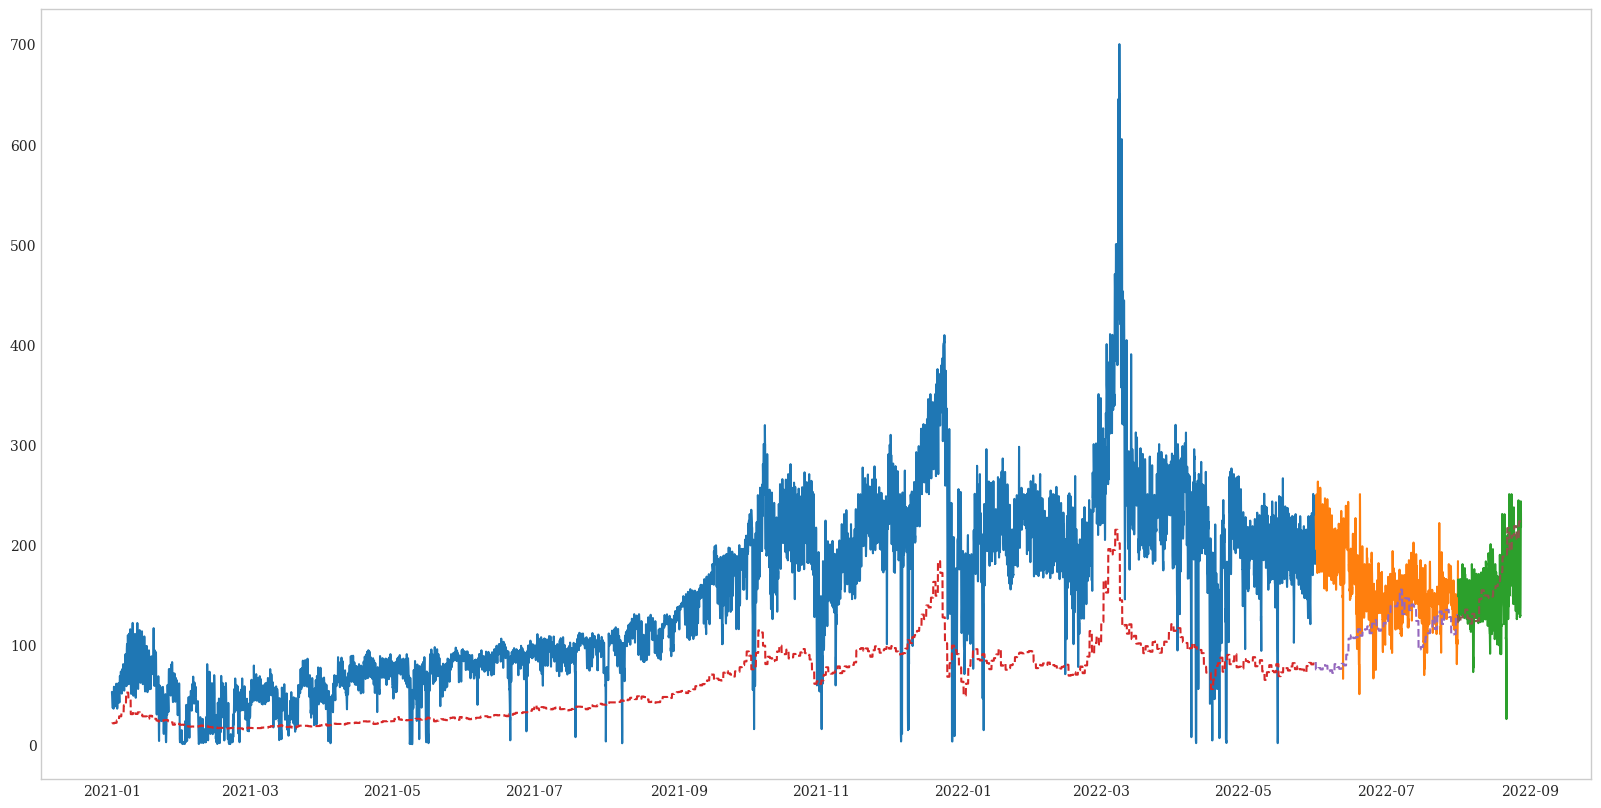

In [18]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.plot(current_db_train.fecha_completa, current_db_train.md_espana)
ax.plot(current_db_val.fecha_completa, current_db_val.md_espana)
ax.plot(current_db_test.fecha_completa, current_db_test.md_espana)
ax.plot(current_db_train.fecha_completa, current_db_train.precio_gas, '--')
ax.plot(current_db_val.fecha_completa, current_db_val.precio_gas, '--')
ax.plot(current_db_test.fecha_completa, current_db_test.precio_gas, '--')
ax.grid()

Train-test split

In [20]:
len(current_db_train), len(current_db_val), len(current_db_test)

(12382, 1464, 649)

In [22]:
X_train = current_db_train[selected_features]
y_train = current_db_train[target_col]

X_val = current_db_val[selected_features]
y_val = current_db_val[target_col]

X_test = current_db_test[selected_features]
y_test = current_db_test[target_col]

In [23]:
X_train_val = X_train.append(X_val)
y_train_val = y_train.append(y_val)

In [24]:
current_db_train_val = current_db_train.append(current_db_val)

In [25]:
seeds = np.random.randint(1, 999999, 50)

In [26]:
scaler = MinMaxScaler()
scaler_obj = MinMaxScaler()
scaler.fit(X_train)
scaler_obj.fit(y_train.to_numpy().reshape(-1, 1))

X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

y_train_norm = scaler_obj.transform(y_train.to_numpy().reshape(-1, 1)).reshape(len(y_train))
y_val_norm = scaler_obj.transform(y_val.to_numpy().reshape(-1, 1)).reshape(len(y_val))
y_test_norm = scaler_obj.transform(y_test.to_numpy().reshape(-1, 1)).reshape(len(y_test))

## Lasso 0.01

In [27]:
model = Lasso(alpha = 0.01)
model.fit(X_train_norm, y_train_norm)

Lasso(alpha=0.01)

In [28]:
features_lasso_001 = sorted(list(X_train.columns[np.abs(model.coef_) > sys.float_info.epsilon]))
features_lasso_001

['max_co2', 'max_gas', 'min_gas']

In [29]:
dict_results_lasso_001 = {'rmse':[], 'mae':[], 'r2':[]}

In [30]:
X_test_lasso_001 = X_test[features_lasso_001]
X_train_lasso_001= X_train[features_lasso_001]
X_val_lasso_001 = X_val[features_lasso_001]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_lasso_001, y_train,
        eval_set=(X_val_lasso_001, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_lasso_001), print_bool=False)
    
    dict_results_lasso_001["r2"].append(test_results["R2"])
    dict_results_lasso_001["rmse"].append(test_results["RMSE"])
    dict_results_lasso_001["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [31]:
results_lasso_001_df = pd.DataFrame(dict_results_lasso_001)
mean_lasso_001_test = results_lasso_001_df.mean()
std_lasso_001_test = results_lasso_001_df.std()
max_lasso_001_test = results_lasso_001_df.max()
min_lasso_001_test = results_lasso_001_df.min()

In [32]:
mean_lasso_001_test, std_lasso_001_test, max_lasso_001_test, min_lasso_001_test

(rmse    36.997832
 mae     29.782763
 r2      -0.436198
 dtype: float64,
 rmse    2.512259
 mae     2.558360
 r2      0.194020
 dtype: float64,
 rmse    43.553970
 mae     36.020285
 r2      -0.033578
 dtype: float64,
 rmse    31.457175
 mae     24.399723
 r2      -0.981341
 dtype: float64)

## Lasso 0.001

In [33]:
model = Lasso(alpha = 0.001)
model.fit(X_train_norm, y_train_norm)

Lasso(alpha=0.001)

In [34]:
features_lasso_0001 = sorted(list(X_train.columns[np.abs(model.coef_) > sys.float_info.epsilon]))
features_lasso_0001

['hueco_termico_previsto_1d',
 'max_carbon',
 'max_co2',
 'min_md_espana',
 'precio_de_utilizacion_de_secundaria_subir_24',
 'precio_gas_24',
 'precio_gas_48',
 'precio_regulacion_terciaria_subir_24',
 'prevision_eolica_diaria_d1',
 'prevision_renovable_diaria_d1',
 'q1_gas',
 'q1_md_espana',
 'q1_md_francia']

In [35]:
dict_results_lasso_0001 = {'rmse':[], 'mae':[], 'r2':[]}

In [36]:
X_test_lasso_0001 = X_test[features_lasso_0001]
X_train_lasso_0001= X_train[features_lasso_0001]
X_val_lasso_0001 = X_val[features_lasso_0001]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_lasso_0001, y_train,
        eval_set=(X_val_lasso_0001, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_lasso_0001), print_bool=False)
    
    dict_results_lasso_0001["r2"].append(test_results["R2"])
    dict_results_lasso_0001["rmse"].append(test_results["RMSE"])
    dict_results_lasso_0001["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [37]:
results_lasso_0001_df = pd.DataFrame(dict_results_lasso_0001)
mean_lasso_0001_test = results_lasso_0001_df.mean()
std_lasso_0001_test = results_lasso_0001_df.std()
max_lasso_0001_test = results_lasso_0001_df.max()
min_lasso_0001_test = results_lasso_0001_df.min()

In [38]:
mean_lasso_0001_test, std_lasso_0001_test, max_lasso_0001_test, min_lasso_0001_test

(rmse    31.451442
 mae     25.000788
 r2      -0.045924
 dtype: float64,
 rmse    3.525595
 mae     3.561164
 r2      0.246576
 dtype: float64,
 rmse    42.493306
 mae     35.484746
 r2       0.300293
 dtype: float64,
 rmse    25.882507
 mae     20.103016
 r2      -0.886013
 dtype: float64)

## Lasso 0.0001

In [39]:
model = Lasso(alpha = 0.0001)
model.fit(X_train_norm, y_train_norm)

Lasso(alpha=0.0001)

In [40]:
features_lasso_00001 = sorted(list(X_train.columns[np.abs(model.coef_) > sys.float_info.epsilon]))
features_lasso_00001

['asignacion_banda_de_regulacion_secundaria_a_bajar_24',
 'asignacion_banda_de_regulacion_secundaria_a_bajar_72',
 'asignacion_banda_de_regulacion_secundaria_a_subir_168',
 'asignacion_gestion_de_desvios_bajar_72',
 'curtosis_md_francia',
 'curtosis_petroleo',
 'dia_semana',
 'error_prevision_demanda_1d_48',
 'error_prevision_demanda_1d_casacion_24',
 'generacion_treal_solar_termica_48',
 'generacion_treal_solar_termica_72',
 'hora',
 'hueco_termico_casado_24',
 'hueco_termico_previsto_1d',
 'hueco_termico_previsto_1d_24',
 'max_residual',
 'md_espana_72',
 'mediana_co2',
 'mediana_md_espana',
 'mi2_espana_24',
 'mi3_espana_24',
 'min_md_espana',
 'phf3_eolica_terrestre_24',
 'precio_banda_de_regulacion_secundaria_168',
 'precio_banda_de_regulacion_secundaria_24',
 'precio_de_los_desvios_medidos_a_bajar_24',
 'precio_de_utilizacion_de_secundaria_subir_24',
 'precio_gas_168',
 'precio_gas_24',
 'precio_gas_48',
 'precio_petroleo',
 'precio_petroleo_168',
 'precio_regulacion_terciaria_su

In [41]:
dict_results_lasso_00001 = {'rmse':[], 'mae':[], 'r2':[]}

In [42]:
X_test_lasso_00001 = X_test[features_lasso_00001]
X_train_lasso_00001= X_train[features_lasso_00001]
X_val_lasso_00001 = X_val[features_lasso_00001]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_lasso_00001, y_train,
        eval_set=(X_val_lasso_00001, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_lasso_00001), print_bool=False)
    
    dict_results_lasso_00001["r2"].append(test_results["R2"])
    dict_results_lasso_00001["rmse"].append(test_results["RMSE"])
    dict_results_lasso_00001["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [43]:
results_lasso_00001_df = pd.DataFrame(dict_results_lasso_00001)
mean_lasso_00001_test = results_lasso_00001_df.mean()
std_lasso_00001_test = results_lasso_00001_df.std()
max_lasso_00001_test = results_lasso_00001_df.max()
min_lasso_00001_test = results_lasso_00001_df.min()

In [44]:
mean_lasso_00001_test, std_lasso_00001_test, max_lasso_00001_test, min_lasso_00001_test

(rmse    29.221246
 mae     22.786294
 r2       0.104188
 dtype: float64,
 rmse    1.962737
 mae     1.814431
 r2      0.125364
 dtype: float64,
 rmse    36.032574
 mae     30.013286
 r2       0.296176
 dtype: float64,
 rmse    25.958545
 mae     19.498882
 r2      -0.356108
 dtype: float64)

## Lasso 0.00001

In [45]:
model = Lasso(alpha = 0.00001)
model.fit(X_train_norm, y_train_norm)

Lasso(alpha=1e-05)

In [46]:
features_lasso_000001 = sorted(list(X_train.columns[np.abs(model.coef_) > sys.float_info.epsilon]))
features_lasso_000001

['asignacion_banda_de_regulacion_secundaria_a_bajar_24',
 'asignacion_banda_de_regulacion_secundaria_a_bajar_72',
 'asignacion_banda_de_regulacion_secundaria_a_subir_168',
 'asignacion_banda_de_regulacion_secundaria_a_subir_24',
 'asignacion_banda_de_regulacion_secundaria_a_subir_48',
 'asignacion_banda_de_regulacion_secundaria_a_subir_72',
 'asignacion_gestion_de_desvios_bajar_24',
 'asignacion_gestion_de_desvios_bajar_48',
 'asignacion_gestion_de_desvios_bajar_72',
 'asignacion_gestion_de_desvios_subir_168',
 'asignacion_gestion_de_desvios_subir_48',
 'asignacion_gestion_de_desvios_subir_72',
 'asignacion_regulacion_terciaria_bajar_24',
 'asignacion_regulacion_terciaria_bajar_72',
 'asignacion_regulacion_terciaria_subir_168',
 'asignacion_regulacion_terciaria_subir_24',
 'asignacion_regulacion_terciaria_subir_48',
 'asignacion_regulacion_terciaria_subir_72',
 'coste_asignacion_de_banda_secundaria_48',
 'curtosis_carbon',
 'curtosis_co2',
 'curtosis_eolica',
 'curtosis_gas',
 'curtosi

In [47]:
dict_results_lasso_000001 = {'rmse':[], 'mae':[], 'r2':[]}

In [48]:
X_test_lasso_000001 = X_test[features_lasso_000001]
X_train_lasso_000001= X_train[features_lasso_000001]
X_val_lasso_000001 = X_val[features_lasso_000001]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_lasso_000001, y_train,
        eval_set=(X_val_lasso_000001, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_lasso_000001), print_bool=False)
    
    dict_results_lasso_000001["r2"].append(test_results["R2"])
    dict_results_lasso_000001["rmse"].append(test_results["RMSE"])
    dict_results_lasso_000001["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [49]:
results_lasso_000001_df = pd.DataFrame(dict_results_lasso_000001)
mean_lasso_000001_test = results_lasso_000001_df.mean()
std_lasso_000001_test = results_lasso_000001_df.std()
max_lasso_000001_test = results_lasso_000001_df.max()
min_lasso_000001_test = results_lasso_000001_df.min()

In [50]:
mean_lasso_000001_test, std_lasso_000001_test, max_lasso_000001_test, min_lasso_000001_test

(rmse    29.151504
 mae     22.893073
 r2       0.104731
 dtype: float64,
 rmse    2.734215
 mae     2.802102
 r2      0.185166
 dtype: float64,
 rmse    42.446838
 mae     37.144017
 r2       0.372188
 dtype: float64,
 rmse    24.516747
 mae     18.932671
 r2      -0.881891
 dtype: float64)

## Boruta

In [51]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)

# if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=model,
                              importance_measure='gini',
                              classification=False)

Feature_Selector.fit(X=X_train_val, y=y_train_val, sample=False,
                        train_or_test = 'test', normalize=True,verbose=True)

# 1 minutos 46 segundos

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [20:52<00:00, 62.60s/it]

68 attributes confirmed important: ['precio_carbon_48', 'mediana_carbon', 'precio_co2', 'precio_de_utilizacion_de_secundaria_bajar_168', 'phf3_eolica_terrestre_24', 'q1_co2', 'precio_regulacion_terciaria_bajar_48', 'max_gas', 'q3_petroleo', 'std_petroleo', 'curtosis_co2', 'skew_petroleo', 'mi3_espana_24', 'max_md_francia', 'hueco_termico_casado_24', 'precio_co2_48', 'precio_co2_24', 'precio_petroleo_168', 'skew_residual', 'precio_co2_72', 'skew_gas', 'hueco_termico_previsto_1d_24', 'precio_regulacion_terciaria_bajar_72', 'md_espana_48', 'max_co2', 'precio_gas_24', 'precio_gas_48', 'precio_banda_de_regulacion_secundaria_24', 'precio_co2_168', 'mediana_co2', 'q3_md_espana', 'error_prevision_eolica_1d_casacion_24', 'prevision_diaria_d1_demanda', 'prevision_renovable_diaria_d1', 'precio_petroleo_24', 'precio_de_los_desvios_medidos_a_bajar_48', 'curtosis_petroleo', 'precio_regulacion_terciaria_subir_24', 'std_carbon', 'generacion_treal_eolica_24', 'mi2_espana_24', 'precio_gas', 'skew_co2', 

In [52]:
subset = Feature_Selector.Subset()
selected_features_boruta = sorted(subset.columns.values)
selected_features_boruta

['asignacion_banda_de_regulacion_secundaria_a_bajar_168',
 'asignacion_banda_de_regulacion_secundaria_a_bajar_48',
 'curtosis_carbon',
 'curtosis_co2',
 'curtosis_gas',
 'curtosis_petroleo',
 'dia_semana',
 'error_prevision_demanda_1d_casacion_24',
 'error_prevision_eolica_1d_casacion_24',
 'error_prevision_eolica_3h_casacion_72',
 'generacion_treal_eolica_24',
 'hueco_termico_casado_24',
 'hueco_termico_previsto_1d',
 'hueco_termico_previsto_1d_24',
 'hueco_termico_real_24',
 'max_co2',
 'max_gas',
 'max_md_francia',
 'md_espana_48',
 'md_francia_24',
 'media_carbon',
 'mediana_carbon',
 'mediana_co2',
 'mi1_espana_24',
 'mi2_espana_24',
 'mi3_espana_24',
 'min_petroleo',
 'phf3_eolica_terrestre_24',
 'precio_banda_de_regulacion_secundaria_24',
 'precio_carbon',
 'precio_carbon_168',
 'precio_carbon_24',
 'precio_carbon_48',
 'precio_co2',
 'precio_co2_168',
 'precio_co2_24',
 'precio_co2_48',
 'precio_co2_72',
 'precio_de_los_desvios_medidos_a_bajar_48',
 'precio_de_utilizacion_de_se

In [53]:
dict_results_boruta = {'rmse':[], 'mae':[], 'r2':[]}

In [54]:
X_test_boruta = X_test[selected_features_boruta]
X_train_boruta = X_train[selected_features_boruta]
X_val_boruta = X_val[selected_features_boruta]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_boruta, y_train,
        eval_set=(X_val_boruta, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_boruta), print_bool=False)
    
    dict_results_boruta["r2"].append(test_results["R2"])
    dict_results_boruta["rmse"].append(test_results["RMSE"])
    dict_results_boruta["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [55]:
results_boruta_df = pd.DataFrame(dict_results_boruta)
mean_boruta_test = results_boruta_df.mean()
std_boruta_test = results_boruta_df.std()
max_boruta_test = results_boruta_df.max()
min_boruta_test = results_boruta_df.min()

In [56]:
mean_boruta_test, std_boruta_test, max_boruta_test, min_boruta_test

(rmse    29.838211
 mae     23.486189
 r2       0.059271
 dtype: float64,
 rmse    3.248398
 mae     3.164922
 r2      0.215790
 dtype: float64,
 rmse    40.550732
 mae     33.855821
 r2       0.412309
 dtype: float64,
 rmse    23.720442
 mae     18.351271
 r2      -0.717517
 dtype: float64)

## PIMP

In [57]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)
model = model.fit(
    X_train, y_train,
    verbose = 0,
    plot=False
)

In [58]:
pimp = PermutationImportance(model, cv='prefit').fit(X_val, y_val)

In [59]:
pimp.feature_importances_

array([ 2.55809275e-02,  1.56826572e-03,  5.83453239e-03,  4.23070099e-02,
        1.69576236e-02,  2.05399831e-02,  2.56241200e-02,  3.38484603e-02,
        0.00000000e+00, -1.40817589e-03,  0.00000000e+00,  0.00000000e+00,
       -5.08744285e-03,  5.94851852e-03,  0.00000000e+00,  0.00000000e+00,
       -8.69073877e-04, -1.39496181e-04,  1.87000427e-02,  9.72826097e-04,
        1.32649257e-02,  7.06770125e-03,  2.13544879e-05, -9.88117616e-04,
        2.07172415e-01,  5.75937841e-03,  2.95320923e-03, -9.73151064e-03,
       -1.66590852e-02,  2.93052084e-02,  0.00000000e+00,  2.04549643e-04,
        1.26520468e-02,  3.04302006e-03,  1.14488818e-02,  3.83118977e-04,
       -1.56847859e-04,  5.64695058e-04,  3.02119049e-03,  6.74444425e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.01028055e-03, -1.47078961e-04,  3.07536136e-03,  1.09306007e-03,
       -2.28695307e-03, -1.00812753e-03, -1.13283396e-05,  0.00000000e+00,
        0.00000000e+00, -

In [65]:
sel = SelectFromModel(pimp,threshold=None, prefit=True)

In [66]:
sel.transform(X_train).shape

(12382, 56)

In [67]:
selected_features_pimp = sorted(list(X_train.columns[sel.get_support()]))
selected_features_pimp

['curtosis_carbon',
 'curtosis_gas',
 'dia_semana',
 'generacion_prevista_solar_termica',
 'generacion_prevista_solar_termica_72',
 'generacion_treal_solar_fotovoltaica_168',
 'hora',
 'hueco_termico_previsto_1d',
 'hueco_termico_previsto_3h_168',
 'max_carbon',
 'max_gas',
 'md_espana_24',
 'md_francia_168',
 'md_francia_48',
 'mediana_gas',
 'mediana_md_francia',
 'mi1_espana_24',
 'mi2_espana_24',
 'mi2_espana_48',
 'mi3_espana_24',
 'mi3_espana_72',
 'min_carbon',
 'min_md_espana',
 'min_petroleo',
 'phf3_solar_fotovoltaica_72',
 'phfc_demanda_programada_24',
 'precio_co2_72',
 'precio_de_los_desvios_medidos_a_bajar_24',
 'precio_de_los_desvios_medidos_a_bajar_48',
 'precio_de_utilizacion_de_secundaria_bajar_168',
 'precio_de_utilizacion_de_secundaria_subir_24',
 'precio_gas',
 'precio_gas_24',
 'precio_gas_48',
 'precio_gas_72',
 'precio_petroleo_168',
 'precio_petroleo_24',
 'precio_regulacion_terciaria_subir_24',
 'precio_regulacion_terciaria_subir_48',
 'prevision_diaria_d1_dem

In [68]:
dict_results_pimp = {'rmse':[], 'mae':[], 'r2':[]}

In [69]:
X_test_pimp = X_test[selected_features_pimp]
X_train_pimp = X_train[selected_features_pimp]
X_val_pimp = X_val[selected_features_pimp]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_pimp, y_train,
        eval_set=(X_val_pimp, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_pimp), print_bool=False)
    
    dict_results_pimp["r2"].append(test_results["R2"])
    dict_results_pimp["rmse"].append(test_results["RMSE"])
    dict_results_pimp["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [70]:
results_pimp_df = pd.DataFrame(dict_results_pimp)
mean_pimp_test = results_pimp_df.mean()
std_pimp_test = results_pimp_df.std()
max_pimp_test = results_pimp_df.max()
min_pimp_test = results_pimp_df.min()

In [71]:
mean_pimp_test, std_pimp_test, max_pimp_test, min_pimp_test

(rmse    29.489386
 mae     23.313851
 r2       0.088565
 dtype: float64,
 rmse    1.746684
 mae     1.733948
 r2      0.108469
 dtype: float64,
 rmse    33.963192
 mae     27.721661
 r2       0.283513
 dtype: float64,
 rmse    26.191008
 mae     20.108880
 r2      -0.204816
 dtype: float64)

# Results

In [72]:
nombres = ['Lasso_0.01', 'Lasso_0.001', 'Lasso_0.0001', 'Lasso_0.00001', 'Boruta', 'PIMP']

## MAE

In [73]:
resultados_mae_mean = [mean_lasso_001_test['mae'], mean_lasso_0001_test['mae'], mean_lasso_00001_test['mae'], mean_lasso_000001_test['mae'], mean_boruta_test['mae'], mean_pimp_test['mae']]
resultados_mae_std = [std_lasso_001_test['mae'], std_lasso_0001_test['mae'], std_lasso_00001_test['mae'], std_lasso_000001_test['mae'], std_boruta_test['mae'], std_pimp_test['mae']]
resultados_mae_max = [max_lasso_001_test['mae'], max_lasso_0001_test['mae'], max_lasso_00001_test['mae'], max_lasso_000001_test['mae'], max_boruta_test['mae'], max_pimp_test['mae']]
resultados_mae_min = [min_lasso_001_test['mae'], min_lasso_0001_test['mae'], min_lasso_00001_test['mae'], min_lasso_000001_test['mae'], min_boruta_test['mae'], min_pimp_test['mae']]

(17.0, 38.0)

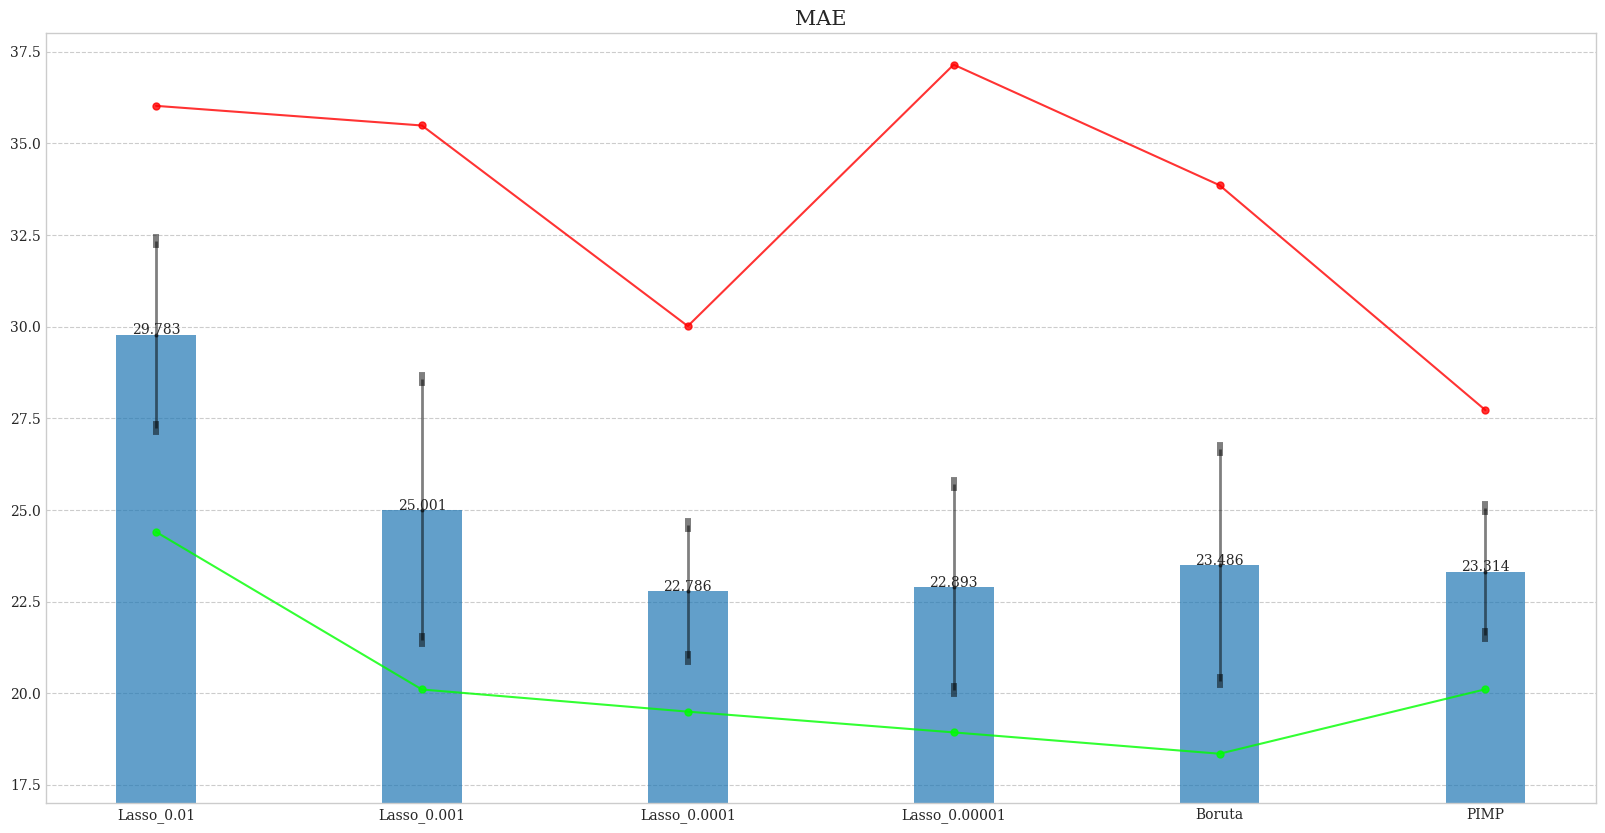

In [74]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.bar(nombres, resultados_mae_mean, alpha = 0.7, width=0.3)
ax.errorbar(nombres, resultados_mae_mean, resultados_mae_std, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax.plot(nombres, resultados_mae_max, color='red', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.plot(nombres, resultados_mae_min, color='lime', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("MAE")
ax.title.set_size(15)
for index,data in enumerate(resultados_mae_mean):
    ax.text(x=index , y =data+0.01 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([17, 38])


## RMSE

In [75]:
resultados_rmse_mean = [mean_lasso_001_test['rmse'], mean_lasso_0001_test['rmse'], mean_lasso_00001_test['rmse'], mean_lasso_000001_test['rmse'], mean_boruta_test['rmse'], mean_pimp_test['rmse']]
resultados_rmse_std = [std_lasso_001_test['rmse'], std_lasso_0001_test['rmse'], std_lasso_00001_test['rmse'], std_lasso_000001_test['rmse'], std_boruta_test['rmse'], std_pimp_test['rmse']]
resultados_rmse_max = [max_lasso_001_test['rmse'], max_lasso_0001_test['rmse'], max_lasso_00001_test['rmse'], max_lasso_000001_test['rmse'], max_boruta_test['rmse'], max_pimp_test['rmse']]
resultados_rmse_min = [min_lasso_001_test['rmse'], min_lasso_0001_test['rmse'], min_lasso_00001_test['rmse'], min_lasso_000001_test['rmse'], min_boruta_test['rmse'], min_pimp_test['rmse']]

(22.0, 44.0)

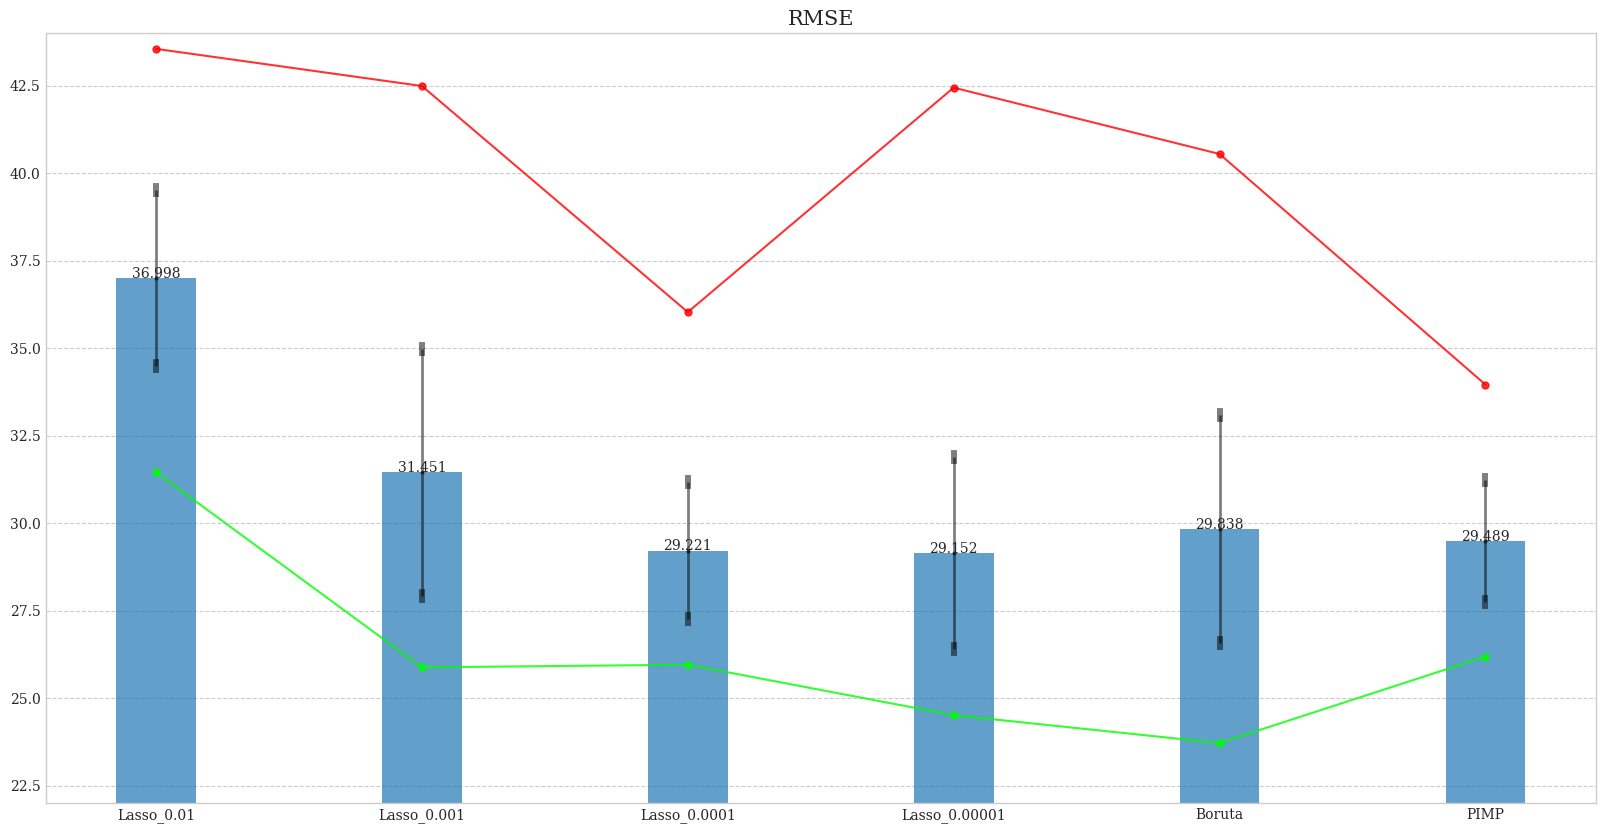

In [76]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.bar(nombres, resultados_rmse_mean, alpha = 0.7, width=0.3)
ax.errorbar(nombres, resultados_rmse_mean, resultados_rmse_std, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax.plot(nombres, resultados_rmse_max, color='red', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.plot(nombres, resultados_rmse_min, color='lime', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("RMSE")
ax.title.set_size(15)
for index,data in enumerate(resultados_rmse_mean):
    ax.text(x=index , y =data+0.01 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([22, 44])

## R2

In [77]:
resultados_r2_mean = [mean_lasso_001_test['r2'], mean_lasso_0001_test['r2'], mean_lasso_00001_test['r2'], mean_lasso_000001_test['r2'], mean_boruta_test['r2'], mean_pimp_test['r2']]
resultados_r2_std = [std_lasso_001_test['r2'], std_lasso_0001_test['r2'], std_lasso_00001_test['r2'], std_lasso_000001_test['r2'], std_boruta_test['r2'], std_pimp_test['r2']]
resultados_r2_max = [max_lasso_001_test['r2'], max_lasso_0001_test['r2'], max_lasso_00001_test['r2'], max_lasso_000001_test['r2'], max_boruta_test['r2'], max_pimp_test['r2']]
resultados_r2_min = [min_lasso_001_test['r2'], min_lasso_0001_test['r2'], min_lasso_00001_test['r2'], min_lasso_000001_test['r2'], min_boruta_test['r2'], min_pimp_test['r2']]

In [78]:
resultados_r2_max, resultados_r2_min

([-0.03357762322395885,
  0.3002927899034019,
  0.2961755397045073,
  0.3721883944396488,
  0.41230876279412976,
  0.2835133923614923],
 [-0.9813406891064724,
  -0.8860130694998734,
  -0.3561079005051737,
  -0.8818905332623985,
  -0.7175170265806874,
  -0.20481579881368273])

(-1.0, 0.5)

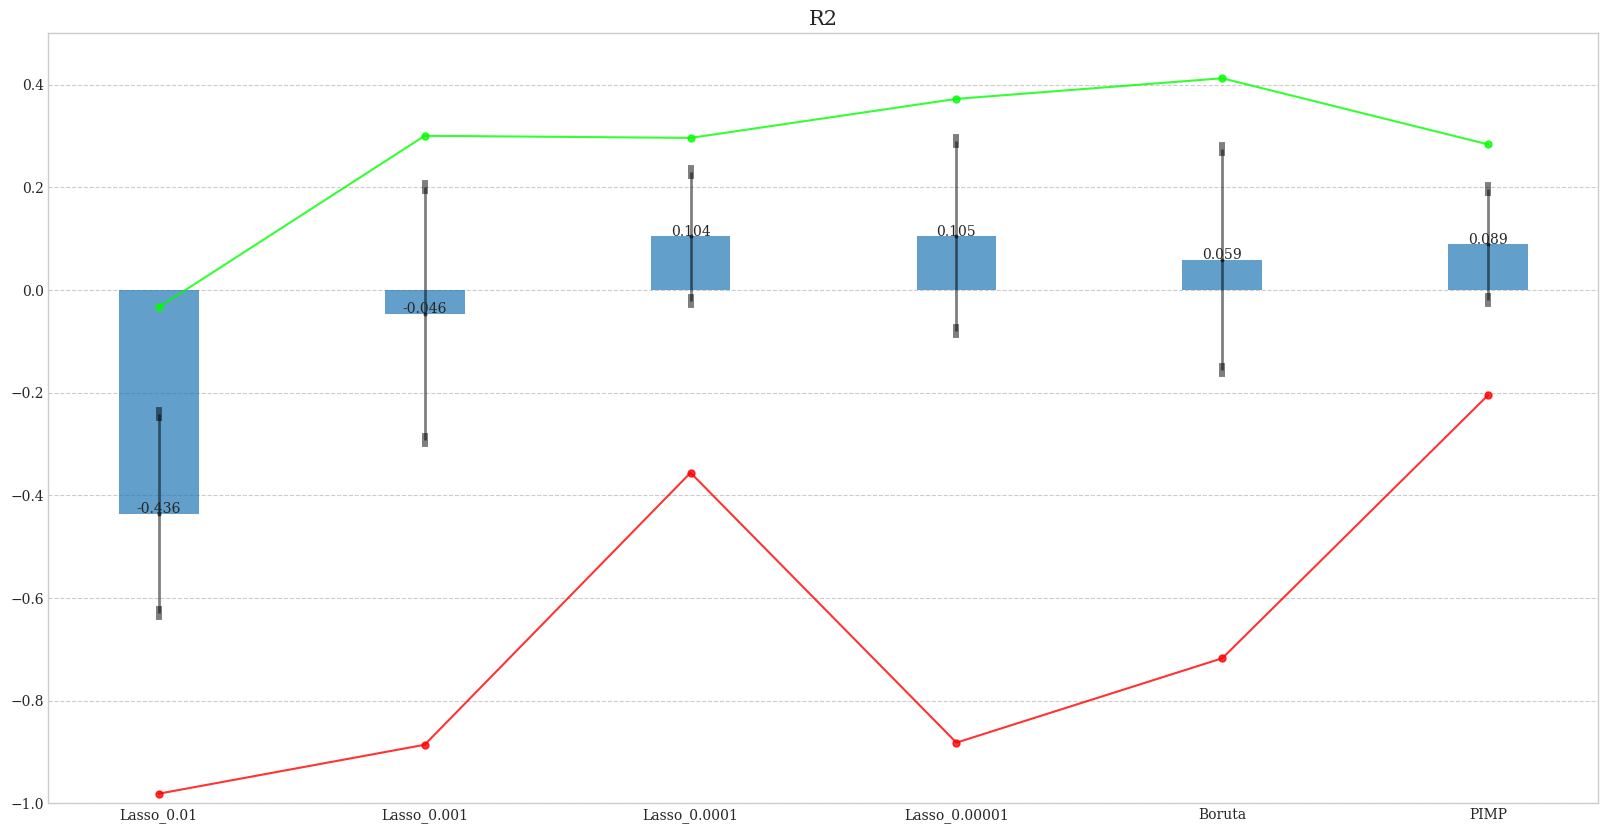

In [79]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.bar(nombres, resultados_r2_mean, alpha = 0.7, width=0.3)
ax.errorbar(nombres, resultados_r2_mean, resultados_r2_std, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax.plot(nombres, resultados_r2_max, color='lime', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.plot(nombres, resultados_r2_min, color='red', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("R2")
ax.title.set_size(15)
for index,data in enumerate(resultados_r2_mean):
    ax.text(x=index , y =data+0.001 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([-1, 0.5])

## Number of variables

In [80]:
n_var = [len(features_lasso_001), len(features_lasso_0001), len(features_lasso_00001), len(features_lasso_000001), len(selected_features_boruta), len(selected_features_pimp)]

(0.0, 160.0)

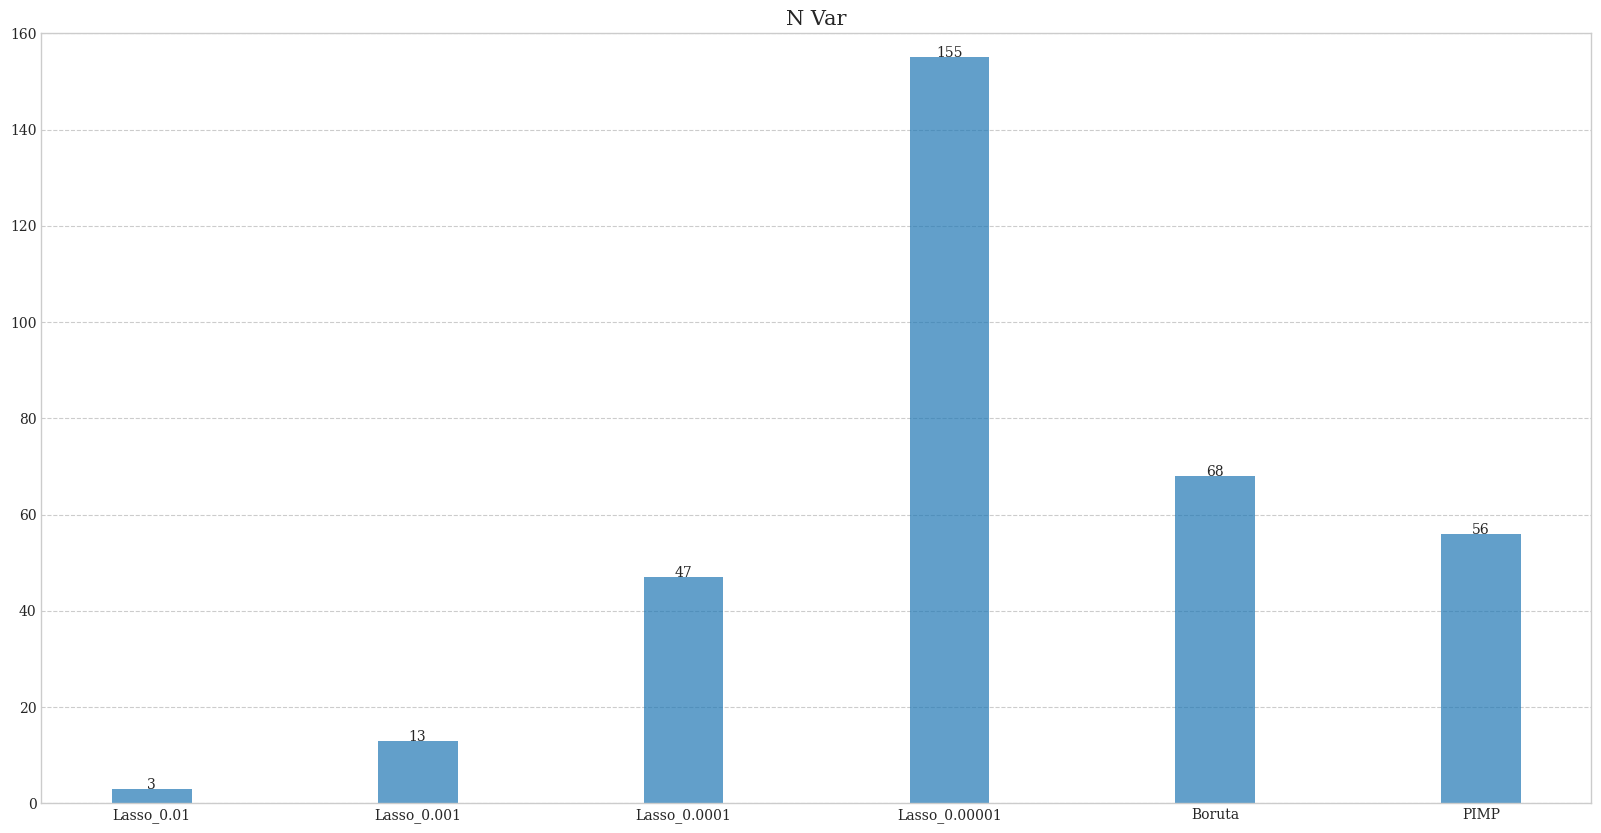

In [81]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
bars = ax.bar(nombres, n_var, alpha = 0.7, width=0.3)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("N Var")
ax.title.set_size(15)
for index,data in enumerate(n_var):
    ax.text(x=index , y =data+0.01 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([0, 160])